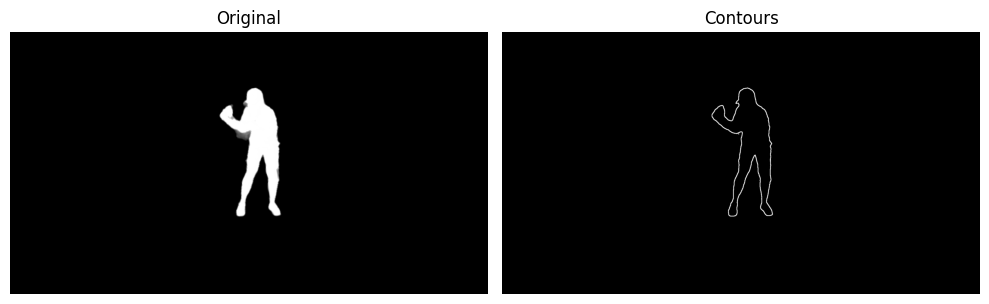

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image in grayscale
img = cv2.imread('pose_mask.png', cv2.IMREAD_GRAYSCALE)

# Check if the image loaded correctly
if img is None:
    raise ValueError("Image not found or cannot be read. Check the file path.")

# Threshold to binary
_, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

# Ensure binary is uint8
binary = binary.astype(np.uint8)


# Find contours
# You can also get the hierarchy info if needed
contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Draw all contours
# Create a blank canvas for drawing
contour_img = np.zeros(binary.shape, dtype=np.uint8)

# Draw contours
cv2.drawContours(contour_img, contours, -1, 255, 2)  # Draw all levels

# Show using matplotlib
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Contours")
plt.imshow(contour_img, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()


In [14]:
# ...existing code...
if np.all(np.isin(binary, [0, 255])):
    print("Array contains only 0 and 1")
else:
    print("Array contains values other than 0 and 1")
# ...existing code...

Array contains only 0 and 1


In [9]:
!pip install ipywidgets opencv-python matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 717.8 kB/s eta 0:00:00a 0:00:01


In [25]:
!pip install scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 9.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 8.6 MB/s eta 0:00:00ta 0:00:01
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.5.0
    Uninstalling Pillow-9.5.0:
      Successfully uninstalled Pillow-9.5.0


In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from collections import deque

# Video setup
video_path = 'martin_video.MP4'
cap = cv2.VideoCapture(video_path)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
cap.release()

# Buffer for smoothing curvature (optional)
curvature_buffer = deque(maxlen=5)

def visualize_frame(frame_number):
    N = 10  # number of previous frames to consider
    gray_buffer = []

    # Load previous N frames
    cap = cv2.VideoCapture(video_path)
    start_frame = max(0, frame_number - N)
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    for _ in range(N):
        ret, frame = cap.read()
        if not ret:
            continue
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray_buffer.append(gray)

    # Load current frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret2, frame2 = cap.read()
    cap.release()
    if not ret2:
        print(f"❌ Failed to read current frame at {frame_number}")
        return
    gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

    # Contrast enhancement (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_gray = clahe.apply(gray2)

    # Motion mask from N-frame difference (max diff)
    motion_mask = np.zeros_like(gray2, dtype=np.uint8)
    for past_gray in gray_buffer:
        diff = cv2.absdiff(gray2, past_gray)
        motion_mask = np.maximum(motion_mask, diff)

    # Morphological closing to fill shaft gaps
    kernel = np.ones((3, 3), np.uint8)
    closed_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    # Further dilation to connect shaft segments
    dilated = cv2.dilate(closed_mask, kernel, iterations=1)

    # Detect lines with Hough Transform
    overlay = frame2.copy()
    shaft_lines = []
    lines = cv2.HoughLinesP(dilated, 1, np.pi / 180, threshold=40, minLineLength=20, maxLineGap=10)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            length = np.hypot(x2 - x1, y2 - y1)
            if length > 30 and abs(x2 - x1) < 40:  # Vertical-ish filter
                shaft_lines.append(((x1, y1), (x2, y2)))
                cv2.line(overlay, (x1, y1), (x2, y2), (255, 0, 0), 2)

    # Curve fitting from shaft lines
    curvature_value = None
    all_points = []
    for (x1, y1), (x2, y2) in shaft_lines:
        all_points.extend([(x1, y1), (x2, y2)])
    if len(all_points) >= 6:
        points = np.array(all_points)
        xs, ys = points[:, 0], points[:, 1]
        try:
            coeffs = np.polyfit(ys, xs, 2)  # Fit x = ay^2 + by + c
            curve_ys = np.linspace(min(ys), max(ys), 100)
            curve_xs = coeffs[0]*curve_ys**2 + coeffs[1]*curve_ys + coeffs[2]

            # Draw curve
            for x, y in zip(curve_xs.astype(int), curve_ys.astype(int)):
                if 0 <= x < overlay.shape[1] and 0 <= y < overlay.shape[0]:
                    overlay[y, x] = (0, 255, 255)

            # Calculate and smooth curvature
            curvature = 2 * coeffs[0]  # second derivative of x(y)
            curvature_buffer.append(curvature)
            curvature_value = np.mean(curvature_buffer)

            # Show curvature
            cv2.putText(overlay, f"Curvature: {curvature_value:.4f}", (30, 40),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
        except Exception as e:
            print("⚠️ Curve fit failed:", e)

    # Visualization
    titles = [
        f"Original Frame #{frame_number}",
        "CLAHE Enhanced",
        "Max Motion Mask (last 10)",
        "Closed Mask (fill gaps)",
        "Dilated Mask",
        "Shaft Overlay (Lines + Curve)"
    ]
    images = [
        cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB),
        enhanced_gray,
        motion_mask,
        closed_mask,
        dilated,
        cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
    ]

    plt.figure(figsize=(20, 8))
    for i in range(len(images)):
        plt.subplot(2, 3, i + 1)
        cmap = 'gray' if len(images[i].shape) == 2 else None
        plt.imshow(images[i], cmap=cmap)
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Interactive slider
interact(visualize_frame, frame_number=IntSlider(min=10, max=total_frames - 1, step=1, value=100))


interactive(children=(IntSlider(value=100, description='frame_number', max=745, min=10), Output()), _dom_class…

<function __main__.visualize_frame(frame_number)>

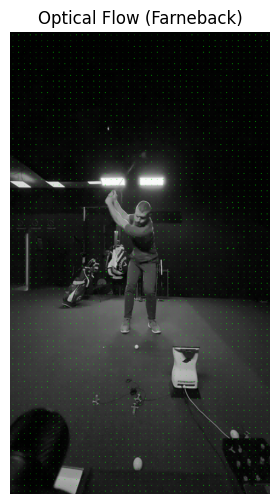

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def draw_optical_flow(prev_gray, next_gray, step=16):
    flow = cv2.calcOpticalFlowFarneback(prev_gray, next_gray, None,
                                         pyr_scale=0.5, levels=3, winsize=15,
                                         iterations=3, poly_n=5, poly_sigma=1.2, flags=0)

    h, w = prev_gray.shape
    y, x = np.mgrid[step//2:h:step, step//2:w:step].astype(int)
    fx, fy = flow[y, x].T

    # Create RGB image to draw flow
    vis = cv2.cvtColor(prev_gray, cv2.COLOR_GRAY2BGR)
    for (x1, y1, dx, dy) in zip(x.flatten(), y.flatten(), fx.flatten(), fy.flatten()):
        cv2.arrowedLine(vis, (x1, y1), (int(x1 + dx), int(y1 + dy)), (0, 255, 0), 1, tipLength=0.4)
    return vis

# Load two frames
video_path = 'martin_video.MP4'
cap = cv2.VideoCapture(video_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, 299)
ret1, frame1 = cap.read()
ret2, frame2 = cap.read()
cap.release()

if ret1 and ret2:
    gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

    flow_vis = draw_optical_flow(gray1, gray2)

    # Display
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(flow_vis, cv2.COLOR_BGR2RGB))
    plt.title("Optical Flow (Farneback)")
    plt.axis("off")
    plt.show()
else:
    print("❌ Could not load frames")


## YOLO V11

In [2]:
import cv2
import numpy as np
from ultralytics import YOLO

video_path = '/Users/ivan/Downloads/golf-video (5).mp4'
output_path = "segmented_output.mp4"
model = YOLO("models/yolo11s-seg.pt")

cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (w, h))

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Run YOLO segmentation
    results = model(frame)
    result = results[0]

    # Overlay masks if present
    if result.masks is not None:
        mask = np.zeros_like(frame)

        best_conf = 0
        best_mask = None

        for i, seg in enumerate(result.masks.data):
            class_id = int(result.boxes.cls[i])
            conf = float(result.boxes.conf[i])

            if class_id != 0:
                continue  # Only 'person'

            if conf > best_conf:
                best_conf = conf
                best_mask = seg.cpu().numpy().astype(np.uint8) * 255

        if best_mask is not None:
            best_mask = cv2.resize(best_mask, (w, h))

            # Use a smaller blur kernel
            smoothed = cv2.GaussianBlur(best_mask, (7, 7), 0)

            # Use a smaller morphological kernel
            kernel = np.ones((3, 3), np.uint8)
            smoothed = cv2.morphologyEx(smoothed, cv2.MORPH_CLOSE, kernel, iterations=1)
            smoothed = cv2.morphologyEx(smoothed, cv2.MORPH_OPEN, kernel, iterations=1)

            # Threshold to binary
            _, smoothed = cv2.threshold(smoothed, 127, 255, cv2.THRESH_BINARY)

            # Find contours
            contours, _ = cv2.findContours(smoothed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Draw filled mask (optional)
            mask[smoothed > 0] = (0, 255, 0)

            # Draw contour lines on the original frame (in red)
            cv2.drawContours(mask, contours, -1, (0, 0, 255), thickness=2)

            # Blend final result
            overlay = cv2.addWeighted(frame, 0.7, mask, 0.3, 0)

        else:
            overlay = frame
    else:
        overlay = frame


    out.write(overlay)

cap.release()
out.release()
print(f"Saved segmentation video to {output_path}")


0: 384x640 1 person, 1 backpack, 164.2ms
Speed: 8.7ms preprocess, 164.2ms inference, 9.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 backpack, 130.6ms
Speed: 2.1ms preprocess, 130.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 backpack, 130.2ms
Speed: 2.1ms preprocess, 130.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 backpack, 121.1ms
Speed: 2.8ms preprocess, 121.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 backpack, 116.1ms
Speed: 1.6ms preprocess, 116.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 backpack, 112.9ms
Speed: 2.4ms preprocess, 112.9ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 backpack, 119.2ms
Speed: 3.0ms preprocess, 119.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person

### CoreML Conversion

In [24]:
import coremltools as ct

version = "v1.0.0"
mlpackage_path = "yolo11s-seg.mlpackage"  # or .mlmodel

# Load
ct_model = ct.models.MLModel(mlpackage_path)

# Metadata
ct_model.short_description = "Segmentation Model"
ct_model.author = "IdeasLab - Ivan Hutomo"
ct_model.license = "MIT"
ct_model.version = f"Segmentation Model: {version}"

# Save as new file
ct_model.save("yolo11s-seg-ideaslab.mlpackage")


In [ ]:
import numpy as np
import cv2
from PIL import Image
import coremltools as ct

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

# Load CoreML model
mlmodel = ct.models.MLModel("models/yolo11s-seg-ideaslab.mlpackage")

# Input/output settings
video_path = '/Users/ivan/Downloads/golf-video (5).mp4'
output_path = "segmented_output_coreml_best_person.mp4"

cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (w, h))

input_size = (640, 640)
CLASS_COUNT = 80
PERSON_CLASS_ID = 0
VAR_KEY = "var_1369"  # detection head: boxes + mask coeffs
PROTOS_KEY = "p"      # prototype masks: (1, 32, 160, 160)
N_MASK = 32           # number of mask coefficients

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Resize and prepare input
    resized = cv2.resize(frame, input_size)
    rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(rgb)

    # Inference
    prediction = mlmodel.predict({"image": pil_image})
    output = prediction[VAR_KEY][0]        # shape: (116, 8400)
    protos = prediction[PROTOS_KEY][0]     # shape: (32, 160, 160)
    protos = protos.reshape(N_MASK, -1)    # (32, 25600)

    # Extract components
    boxes = output[0:4]                   # shape: (4, N)
    objectness = sigmoid(output[4])      # shape: (N,)
    class_logits = output[5:5+CLASS_COUNT]  # shape: (80, N)
    mask_coeffs_all = output[-N_MASK:]   # shape: (32, N)

    # Compute class probs and scores
    class_probs = softmax(class_logits)  # shape: (80, N)
    person_scores = class_probs[PERSON_CLASS_ID]  # shape: (N,)
    final_scores = objectness * person_scores     # shape: (N,)

    # Filter valid person predictions
    valid_mask = (objectness > 0.51)
    valid_scores = np.where(valid_mask, final_scores, -np.inf)

    # Find best
    best_idx = np.argmax(valid_scores)
    if valid_scores[best_idx] != -np.inf:
        cx, cy, bw, bh = boxes[:, best_idx]
        coeffs = mask_coeffs_all[:, best_idx]
        best_score = valid_scores[best_idx]
        best_info = (cx, cy, bw, bh, coeffs)
    else:
        best_info = None


    # If a valid person was found, draw it
    if best_info:
        cx, cy, bw, bh, coeffs = best_info

        # Compose mask
        mask_flat = np.dot(coeffs, protos)  # (25600,)
        mask = sigmoid(mask_flat).reshape(160, 160)
        mask_resized = cv2.resize(mask, (w, h))
        binary_mask = (mask_resized > 0.5).astype(np.uint8) * 255

        # Convert bbox to image coordinates
        # input size is fixed to YOLO Model input size (640, 640)
        cx *= w / input_size[0]
        cy *= h / input_size[1]
        bw *= w / input_size[0]
        bh *= h / input_size[1]
        x1 = int(max(cx - bw / 2, 0))
        y1 = int(max(cy - bh / 2, 0))
        x2 = int(min(cx + bw / 2, w))
        y2 = int(min(cy + bh / 2, h))

        # Crop binary mask to bounding box (This is what looks like a person in mediapipe)
        cropped_mask = binary_mask[y1:y2, x1:x2]

        # Find contours in the cropped mask/ TODO: In apple swift, we can use vision framework
        contours, hierarchy = cv2.findContours(cropped_mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

        # Offset contours to match full image coordinates
        offset_contours = [cnt + np.array([[[x1, y1]]]) for cnt in contours]

        # Draw red contours only inside the bounding box
        overlayed = frame.copy()
        cv2.drawContours(overlayed, offset_contours, -1, (0, 0, 255), 2)

        # Draw bounding box and label
        cv2.rectangle(overlayed, (x1, y1), (x2, y2), (0, 255, 0), 2)

        out.write(overlayed)
    else:
        out.write(frame)

cap.release()
out.release()
print(f"✅ Saved to {output_path}")


✅ Saved to segmented_output_coreml_best_person.mp4


## DeepLab v3

In [3]:
import cv2
import torch
import torchvision
import numpy as np
from tqdm import tqdm

# Load DeepLabV3+ model
model = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=True)
model.eval()

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define preprocessing
def preprocess(frame):
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (520, 520))
    img = torch.from_numpy(img).float().permute(2, 0, 1) / 255.0
    return img.unsqueeze(0).to(device)

# Define postprocessing
def postprocess(output, orig_shape):
    mask = output.argmax(1).squeeze().cpu().numpy()
    person_mask = (mask == 15).astype(np.uint8) * 255  # COCO class 15 = person
    person_mask = cv2.resize(person_mask, (orig_shape[1], orig_shape[0]))
    return person_mask

# Input/output video
input_path = "martin_video.mp4"
output_path = "output_segmented.mp4"

cap = cv2.VideoCapture(input_path)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = cap.get(cv2.CAP_PROP_FPS)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
pbar = tqdm(total=frame_count)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    input_tensor = preprocess(frame)
    with torch.no_grad():
        output = model(input_tensor)["out"]

    mask = postprocess(output, frame.shape)

    # Overlay mask
    mask_colored = cv2.applyColorMap(mask, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(frame, 0.6, mask_colored, 0.4, 0)

    out.write(overlay)
    pbar.update(1)

pbar.close()
cap.release()
out.release()
print(f"Saved to {output_path}")


/Users/ivan/miniconda3/envs/gopro/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ivan/miniconda3/envs/gopro/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_mobilenet_v3_large-fc3c493d.pth" to /Users/ivan/.cache/torch/hub/checkpoints/deeplabv3_mobilenet_v3_large-fc3c493d.pth
100%|██████████| 42.3M/42.3M [00:01<00:00, 36.5MB/s]
100%|██████████| 746/746 [06:00<00:00,  2.07it/s]

Saved to output_segmented.mp4


# Masks-RCNN

In [4]:
import cv2
import torch
import torchvision
import numpy as np
from tqdm import tqdm

# Load Mask R-CNN model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Preprocess frame
def preprocess(frame):
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = torch.from_numpy(img).float().permute(2, 0, 1) / 255.0
    return img.to(device)

# Overlay mask on frame
def overlay_masks(frame, outputs, score_thresh=0.7):
    mask = np.zeros(frame.shape[:2], dtype=np.uint8)

    for i in range(len(outputs["labels"])):
        label = outputs["labels"][i].item()
        score = outputs["scores"][i].item()

        if label == 1 and score >= score_thresh:  # COCO class 1 = person
            m = outputs["masks"][i, 0].cpu().numpy()
            m = (m > 0.5).astype(np.uint8) * 255
            mask = cv2.bitwise_or(mask, m.astype(np.uint8))

    mask_colored = cv2.applyColorMap(mask, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(frame, 0.6, mask_colored, 0.4, 0)
    return overlay

# Input/output video paths
# Input/output video
input_path = "martin_video.mp4"
output_path = "output_maskrcnn.mp4"

cap = cv2.VideoCapture(input_path)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
pbar = tqdm(total=frame_count)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    input_tensor = preprocess(frame)
    with torch.no_grad():
        preds = model([input_tensor])[0]

    overlay = overlay_masks(frame, preds)
    out.write(overlay)
    pbar.update(1)

pbar.close()
cap.release()
out.release()
print(f"Saved to {output_path}")


/Users/ivan/miniconda3/envs/gopro/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /Users/ivan/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:04<00:00, 35.8MB/s] 
100%|██████████| 746/746 [30:47<00:00,  2.48s/it]

Saved to output_maskrcnn.mp4


In [ ]:
import cv2
import numpy as np

# Load the image
img = cv2.imread("mask_0055.png", cv2.IMREAD_GRAYSCALE)

# Resize for visualization (optional)
img = cv2.resize(img, (512, 512))

# Step 1: Gaussian Blur to reduce noise
blurred = cv2.GaussianBlur(img, (5, 5), 0)

# Step 2: Threshold to binary
_, binary = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY)

# Step 3: Morphological operations to clean mask
kernel = np.ones((5, 5), np.uint8)
cleaned = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel, iterations=2)

# Step 4: Find contours
contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


# Step 5: Select the largest contour (likely the person)
if contours:
    largest_contour = max(contours, key=cv2.contourArea)
    print(f"Largest contour area: {cv2.contourArea(largest_contour)}")

    # Draw the contour
    contour_vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(contour_vis, [largest_contour], -1, (0, 255, 0), 2)

    # Optional: create a mask of just the person
    mask = np.zeros_like(img)
    cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

    # Show results
    cv2.imshow("Original", img)
    cv2.imshow("Cleaned Mask", cleaned)
    cv2.imshow("Contour", contour_vis)
    cv2.imshow("Person Mask", mask)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    print("No contours found!")


Largest contour area: 9605.5


: 